In [3]:
# Copyright (c) 2024 Microsoft
# Licensed under The MIT License [see LICENSE for details]

import os
import re
import json
import math
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# 全局样式设置
sns.set_style("white")
sns.set_theme("poster", style="ticks", font_scale=1.2)
plt.rc("font", family="Times New Roman")
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)


def plot_needle_viz(
    res_file,
    model_name,
    min_context=1000,
    max_context=1000000,
    mode="ours",
    output_path="figures/",
    show=True,
    save=True,
):
    """
    可视化 Needle-in-a-Haystack 测试结果。
    
    参数:
    - res_file: JSON 文件路径，包含 context_length, depth_percent, correct 三列
    - model_name: 模型名称
    - min_context, max_context: 最小和最大上下文长度 (用于输出文件名)
    - mode: ours / streamllm / infllm
    - output_path: 保存路径
    - show: 是否显示图
    - save: 是否保存图和 CSV
    """

    def get_context_size(x, is_128k: bool = False):
        if isinstance(x, str):
            x = float(x)
        if is_128k:
            return f"{round(x / 1000)}K"
        if x > 990000:
            return f"{round(x / 1000000)}M"
        if x <= 10000:
            return "10K" if x > 5000 else "1K"
        if round(x / 1000) == 128:
            return "128K"
        return f"{round(x / 10000)* 10}K"

    # 设置字体大小
    plt.rc("axes", titlesize=25)
    plt.rc("axes", labelsize=25)
    plt.rc("xtick", labelsize=20)
    plt.rc("ytick", labelsize=20)
    plt.rc("legend", fontsize=20)

    # # 读取结果
    # df = pd.read_json(res_file)
    # accuracy_df = df.groupby(["context_length", "depth_percent"])["correct"].mean().reset_index()
    # accuracy_df = accuracy_df.rename(
    #     columns={
    #         "correct": "Score",
    #         "context_length": "Context Length",
    #         "depth_percent": "Document Depth",
    #     }
    # )

    # pivot_table = pd.pivot_table(
    #     accuracy_df,
    #     values="Score",
    #     index=["Document Depth", "Context Length"],
    #     aggfunc="mean",
    # ).reset_index()
    # pivot_table = pivot_table.pivot(
    #     index="Document Depth", columns="Context Length", values="Score"
    # )
    pivot_table = pd.read_csv(res_file, header=0)
    orig_cols = pivot_table.columns.tolist()

    context_cols = [c for c in orig_cols if c != "Document Depth"]
    pivot_table = pivot_table.melt(
    id_vars="Document Depth",
    var_name="Context Length",
    value_name="Score"
    )
    pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score")
    pivot_table = pivot_table[context_cols]
    pivot_table.columns = pivot_table.columns.astype(int)
    pivot_table = pivot_table.sort_index(axis=1)
    pivot_table.columns = pivot_table.columns.astype(str)

    # 配色
    cmap = LinearSegmentedColormap.from_list(
        "custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"]
    )

    plt.figure(figsize=(14, 7))
    ax = sns.heatmap(
        pivot_table,
        fmt="g",
        cmap=cmap,
        vmin=0,
        vmax=1,
    )

    min_context_str = f"{min_context // 1000}K" if min_context >= 1000 else min_context
    max_context_str = f"{max_context // 1000}K" if max_context >= 1000 else max_context

    # 生成标题
    name = ""

    if "Yi" in model_name:
        context = "200K"
    elif any(key in model_name for key in ["Phi", "Qwen2"]):
        context = "128K"
    else:
        context = "128K"

    plt.title(f"Needle in A Haystack {model_name}{name} {context} Context")
    plt.xlabel("Context Length")
    plt.ylabel("Depth Percent (%)")

    # x 轴 ticks
    xtick_labels = pivot_table.columns.values
    xtick_labels = [get_context_size(x, context == "128K") for x in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)) + 0.5, minor=False)
    ax.set_xticklabels(xtick_labels)

    # 白色网格线
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color("white")
        spine.set_linewidth(1)

    for i in range(pivot_table.shape[0]):
        ax.axhline(i, color="white", lw=1)
    for i in range(pivot_table.shape[1]):
        ax.axvline(i, color="white", lw=1)

    plt.xticks(rotation=60)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # 保存
    if save:
        os.makedirs(output_path, exist_ok=True)
        save_path = os.path.join(
            output_path,
            f"needle_viz_{model_name}_{mode}_{min_context_str}_{max_context_str}.pdf",
        )
        df_save_path = os.path.join(
            output_path,
            f"{model_name}_{mode}_{min_context_str}_{max_context_str}.csv",
        )
        pivot_table.to_csv(df_save_path)
        plt.savefig(save_path, dpi=1000)
        print(f"✅ Needle plot saved to {save_path}")
        print(f"✅ Data saved to {df_save_path}")

    if show:
        plt.show()
    else:
        plt.close()

✅ Needle plot saved to figures/needle_viz_QwenLong-L1-32B_ours_1K_1000K.pdf
✅ Data saved to figures/QwenLong-L1-32B_ours_1K_1000K.csv


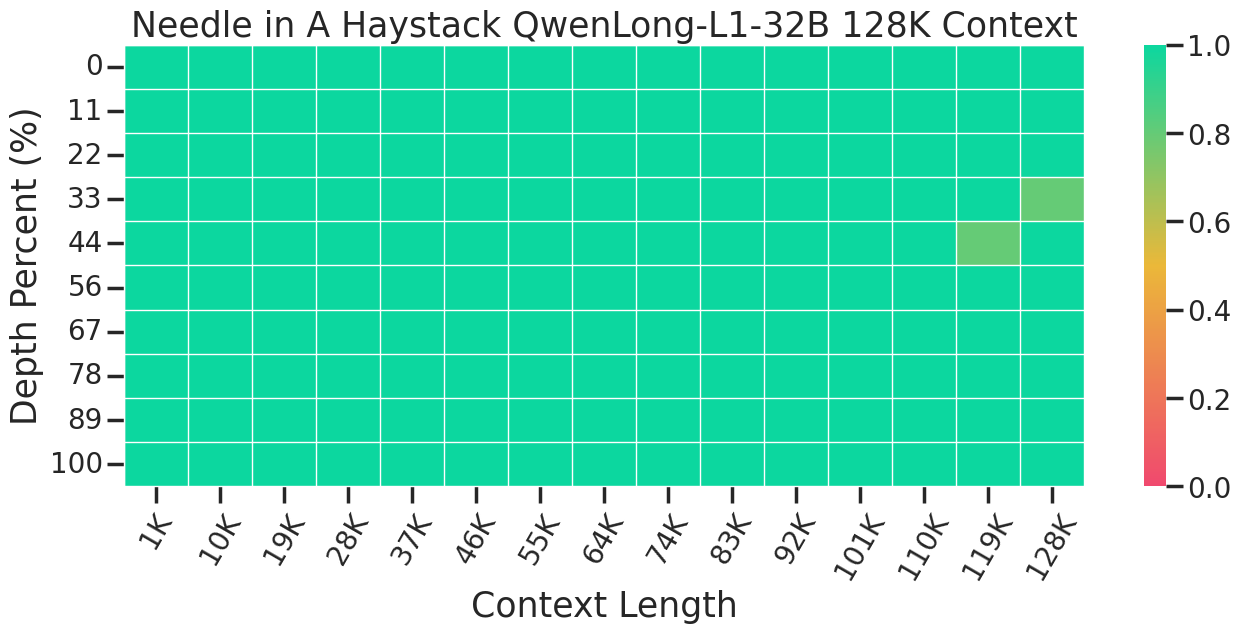

In [5]:
plot_needle_viz("/home/aiscuser/LongContextDataSynth/difficulty_analysis/QwenLong-L1-32B_ours_1K_1000K.csv", "QwenLong-L1-32B")